In [14]:
# Setup: Pull latest code and install package with CUDA support
# Run this cell first. If imports fail, restart kernel and run again.

import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

# Detect environment and set repo path
if os.path.exists("/content"):  # Google Colab
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):  # Lambda Labs / similar
    REPO_DIR = "/workspace/FormationHNCA"
else:
    REPO_DIR = os.path.expanduser("~/FormationHNCA")

# Clone or pull latest
if os.path.exists(REPO_DIR):
    print(f"Pulling latest changes in {REPO_DIR}...")
    result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
    print(result.stdout or "Already up to date.")
else:
    print(f"Cloning repository to {REPO_DIR}...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install JAX with CUDA support (for H100/GPU)
print("Installing JAX with CUDA support...")
subprocess.run([
    sys.executable, "-m", "pip", "install", "-q",
    "jax[cuda12]"
], check=True)

# Install package
print("Installing battle-nca package...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)

# Add src to path as fallback
src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package...

Working directory: /workspace/FormationHNCA
Setup complete!


In [15]:
# Verify JAX GPU setup and clear CUDA memory
import jax
import gc

# Clear any existing JAX/CUDA memory
gc.collect()

# Clear JAX caches
jax.clear_caches()

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

if jax.devices()[0].platform == 'gpu':
    print("GPU acceleration enabled!")
    print("CUDA memory cleared.")
else:
    print("WARNING: Running on CPU. Restart kernel if you just installed CUDA JAX.")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]
GPU acceleration enabled!
CUDA memory cleared.


# Battle NCA Training

This notebook implements the three-phase curriculum for training Hierarchical Neural Cellular Automata for battle simulation.

**Training Phases:**
1. **Phase 1**: Static formation learning (1,500 iterations)
2. **Phase 2**: Multi-formation transitions (2,500 iterations)
3. **Phase 3**: Combat dynamics (4,000 iterations)

In [16]:
# Core imports
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
import pickle
from pathlib import Path

# Battle NCA imports
from battle_nca.core import NCA, perceive
from battle_nca.core.nca import create_seed
from battle_nca.hierarchy import ChildNCA, ParentNCA, HierarchicalNCA
from battle_nca.hierarchy.child_nca import create_army_seed, CHILD_CHANNELS
from battle_nca.combat import FormationTargets, create_formation_target, rotate_formation
from battle_nca.combat.formations import FormationTypes
from battle_nca.combat.losses import formation_loss, total_battle_loss
from battle_nca.training import NCAPool, Trainer, TrainingConfig
from battle_nca.training.optimizers import create_optimizer, normalize_gradients
from battle_nca.utils.visualization import render_state, plot_training_curves

print("All imports successful!")

All imports successful!


## Configuration

In [17]:
# Grid configuration
GRID_SIZE = 64  # 64x64 grid (can scale to 200x200 for full simulation)
NUM_CHANNELS = 24  # Full battle state channels

# RESET: Set to True to retrain from scratch, False to resume from checkpoint
# NOTE: Must be True if switching between goal-conditioned and non-goal-conditioned models
RESET = True  # <-- Set True to train new goal-conditioned model

# Training configuration
config = TrainingConfig(
    batch_size=32,
    pool_size=1024,
    min_steps=128,   # Increased from 64 - more time to form complex shapes
    max_steps=192,   # Increased from 96
    learning_rate=2e-3,
    gradient_clip=1.0,
    damage_samples=3,
    damage_start_epoch=500,
    log_interval=100,
    checkpoint_interval=500
)

# Phase epochs
PHASE1_EPOCHS = 800
PHASE2_EPOCHS = 5000  # Increased for multi-formation learning
PHASE3_EPOCHS = 4000

# Rotation augmentation settings
USE_ROTATION_AUGMENTATION = True  # Enable random rotation of targets
ROTATION_CONTINUOUS = True  # Use continuous angles (vs 90° increments)

# Random seed
SEED = 42

# Checkpoint path
CHECKPOINT_PATH = Path('checkpoints/battle_nca_trained.pkl')
CHECKPOINT_PATH.parent.mkdir(exist_ok=True)

print(f"NCA steps per training iteration: {config.min_steps}-{config.max_steps}")
print(f"This gives cells more time to coordinate into complex formations")

NCA steps per training iteration: 128-192
This gives cells more time to coordinate into complex formations


## Create Model and Initialize

In [18]:
# Create child NCA model
child_nca = ChildNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=128,
    fire_rate=0.5,
    use_circular_padding=True
)

# Create seed state
seed = create_army_seed(
    height=GRID_SIZE,
    width=GRID_SIZE,
    team_color=(1.0, 0.0, 0.0),  # Red team
    unit_type=0,
    formation_id=0,
    spawn_region=(GRID_SIZE//2 - 2, GRID_SIZE//2 + 2, GRID_SIZE//2 - 2, GRID_SIZE//2 + 2)
)

print(f"Seed shape: {seed.shape}")
print(f"Seed active cells: {jnp.sum(seed[..., 3] > 0.5)}")

Seed shape: (64, 64, 24)
Seed active cells: 16


In [19]:
# Initialize model parameters or load from checkpoint
key = jax.random.PRNGKey(SEED)
key, init_key = jax.random.split(key)

# Count parameters helper
def count_params(params):
    return sum(p.size for p in jax.tree_util.tree_leaves(params))

# Check for existing checkpoint
loaded_checkpoint = None
skip_phase1 = False
skip_phase2 = False
effective_reset = RESET

if not RESET and CHECKPOINT_PATH.exists():
    print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
    with open(CHECKPOINT_PATH, 'rb') as f:
        loaded_checkpoint = pickle.load(f)
    
    # Check if checkpoint is goal-conditioned (compatible with current training)
    checkpoint_goal_conditioned = loaded_checkpoint.get('config', {}).get('goal_conditioned', False)
    
    if not checkpoint_goal_conditioned:
        print("  WARNING: Checkpoint was trained WITHOUT goal conditioning!")
        print("  Cannot resume - model architecture is incompatible.")
        print("  Forcing RESET=True to train new goal-conditioned model.")
        effective_reset = True
        loaded_checkpoint = None
    else:
        params = loaded_checkpoint['params']
        print(f"  Loaded goal-conditioned model with {count_params(params):,} parameters")
        
        if 'metrics' in loaded_checkpoint:
            p1_epochs = len(loaded_checkpoint['metrics'].get('phase1_losses', []))
            p2_epochs = len(loaded_checkpoint['metrics'].get('phase2_losses', []))
            print(f"  Previous Phase 1 epochs: {p1_epochs}")
            print(f"  Previous Phase 2 epochs: {p2_epochs}")
            
            # Skip phases that are already complete
            if p1_epochs >= PHASE1_EPOCHS * 0.5:  # At least 50% complete
                skip_phase1 = True
                print("  -> Skipping Phase 1 (already trained)")
            if p2_epochs >= PHASE2_EPOCHS * 0.5:
                skip_phase2 = True
                print("  -> Skipping Phase 2 (already trained)")

if effective_reset or loaded_checkpoint is None:
    if RESET:
        print("RESET=True: Training from scratch...")
    else:
        print("No compatible checkpoint found. Initializing fresh model...")
    
    # IMPORTANT: Initialize WITH parent_signal so Conv layers expect 74 input channels
    dummy_signal = jnp.zeros((GRID_SIZE, GRID_SIZE, 2))  # 2-channel goal signal
    variables = child_nca.init(init_key, seed, jax.random.PRNGKey(0), parent_signal=dummy_signal)
    params = variables['params']
    print("  Initialized goal-conditioned model (with parent_signal)")

print(f"Total parameters: {count_params(params):,}")

RESET=True: Training from scratch...
  Initialized goal-conditioned model (with parent_signal)
Total parameters: 36,466


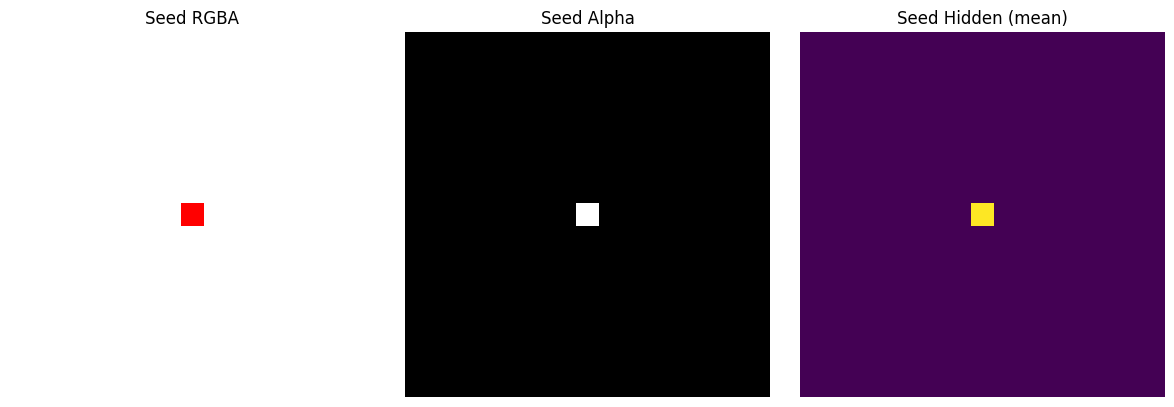

In [20]:
# Visualize seed
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# RGBA
axes[0].imshow(np.clip(seed[..., :4], 0, 1))
axes[0].set_title('Seed RGBA')
axes[0].axis('off')

# Alpha channel
axes[1].imshow(seed[..., 3], cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Seed Alpha')
axes[1].axis('off')

# Hidden channels (mean)
axes[2].imshow(seed[..., 15:].mean(axis=-1), cmap='viridis')
axes[2].set_title('Seed Hidden (mean)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Create Target Formations

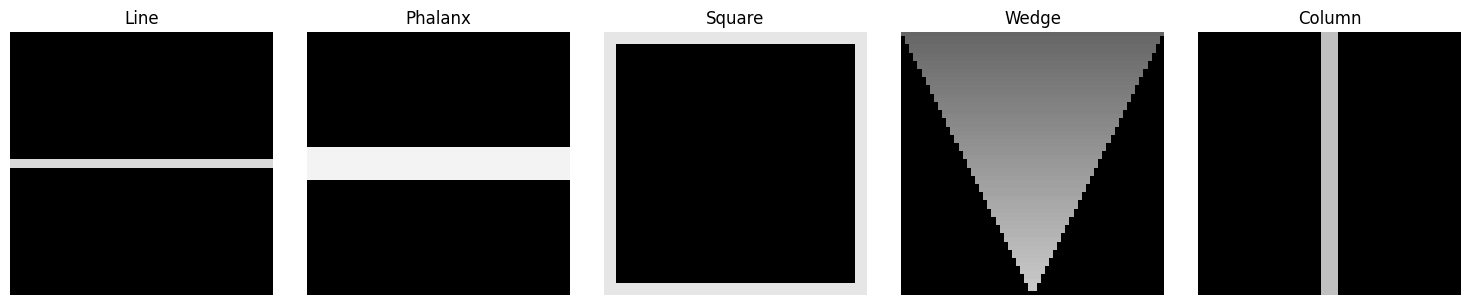

In [21]:
# Create all formation targets
targets = {
    'line': FormationTargets.line(GRID_SIZE, GRID_SIZE),
    'phalanx': FormationTargets.phalanx(GRID_SIZE, GRID_SIZE, depth=8),
    'square': FormationTargets.square(GRID_SIZE, GRID_SIZE, thickness=3),
    'wedge': FormationTargets.wedge(GRID_SIZE, GRID_SIZE),
    'column': FormationTargets.column(GRID_SIZE, GRID_SIZE, col_width=4),
}

# Visualize targets
fig, axes = plt.subplots(1, len(targets), figsize=(15, 3))

for ax, (name, target) in zip(axes, targets.items()):
    ax.imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
    ax.set_title(name.capitalize())
    ax.axis('off')

plt.tight_layout()
plt.show()

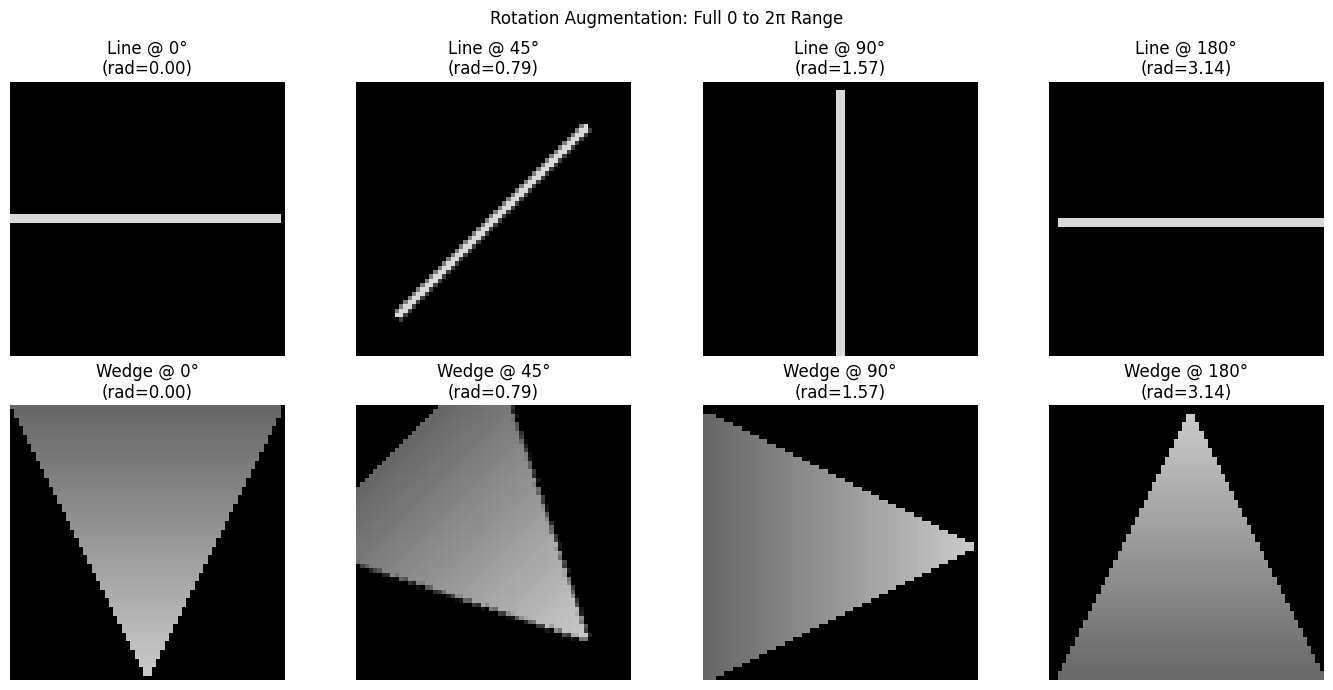


Training uses random angles in [0, 2π] ≈ [0, 6.28] radians


In [22]:
# Visualize rotated formation variants (full 360° range)
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

# Show line formation at different angles across full 2π range
line_target = targets['line']
angles = [0, jnp.pi/4, jnp.pi/2, jnp.pi, 5*jnp.pi/4, 3*jnp.pi/2, 7*jnp.pi/4, 2*jnp.pi - 0.01]
angle_labels = ['0°', '45°', '90°', '180°', '225°', '270°', '315°', '360°']

for ax, angle, label in zip(axes[0], angles, angle_labels):
    rotated = rotate_formation(line_target, float(angle))
    ax.imshow(rotated[..., 3], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Line @ {label}\n(rad={float(angle):.2f})')
    ax.axis('off')

# Show wedge formation at different angles
wedge_target = targets['wedge']
for ax, angle, label in zip(axes[1], angles, angle_labels):
    rotated = rotate_formation(wedge_target, float(angle))
    ax.imshow(rotated[..., 3], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Wedge @ {label}\n(rad={float(angle):.2f})')
    ax.axis('off')

plt.suptitle('Rotation Augmentation: Full 0 to 2π Range')
plt.tight_layout()
plt.show()

print(f"\nTraining uses random angles in [0, 2π] ≈ [0, {2*np.pi:.2f}] radians")

## Phase 1: Static Formation Learning

In [23]:
# Create optimizer
optimizer = create_optimizer(
    learning_rate=config.learning_rate,
    gradient_clip=config.gradient_clip
)

# Create training state
state = train_state.TrainState.create(
    apply_fn=child_nca.apply,
    params=params,
    tx=optimizer
)

# Create pool
pool = NCAPool(seed, config.pool_size)

# Target formation for Phase 1
target = targets['line']

In [ ]:
# JIT-compiled training step with goal conditioning, intermediate supervision, and mass conservation
# Key principle: Cells represent soldiers with object permanence. Mass should be conserved
# (redistributed into formations) unless explicit damage is applied.

from battle_nca.hierarchy.child_nca import CHILD_CHANNELS

# Number of checkpoints for intermediate loss (prevents pattern degeneration)
NUM_CHECKPOINTS = 4  # Compute loss at 4 evenly-spaced points during simulation

# Mass conservation weight - how strongly to enforce soldier preservation
MASS_CONSERVATION_WEIGHT = 0.5  # Significant weight since this is a physical constraint

@partial(jax.jit, static_argnums=(5,))
def train_step(state, batch, target, key, formation_signal, num_steps):
    """Single training step with goal conditioning, intermediate supervision, and mass conservation.
    
    Key principles:
    1. Formation signal is written into state's parent signal channels (11-12)
    2. Loss is computed at multiple checkpoints to prevent mid-simulation degeneration
    3. Mass conservation: total soldier count should remain constant (they move, not vanish)
    """
    def loss_fn(params):
        keys = jax.random.split(key, num_steps)
        
        # Record initial mass - this is the number of "soldiers" that must be preserved
        initial_mass = jnp.sum(batch[..., 3], axis=(1, 2))  # Per-sample mass (B,)
        
        # Compute checkpoint indices (evenly spaced)
        checkpoint_interval = num_steps // NUM_CHECKPOINTS
        checkpoint_indices = jnp.array([
            (i + 1) * checkpoint_interval - 1 for i in range(NUM_CHECKPOINTS)
        ])
        
        def step(carry, inputs):
            step_idx, subkey = inputs
            state_in = carry
            
            # Write formation signal into state's parent signal channels
            state_in = state_in.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
                formation_signal[..., :2]  # Channels 11-12
            )
            
            # Run NCA step
            new_state = child_nca.apply(
                {'params': params}, 
                state_in, 
                subkey,
                parent_signal=formation_signal
            )
            return new_state, new_state  # Return state for both carry and output
        
        # Run all steps, collecting all intermediate states
        step_inputs = (jnp.arange(num_steps), keys)
        final, all_states = jax.lax.scan(step, batch, step_inputs)
        
        # === Formation Loss at Checkpoints ===
        # Weighted: later checkpoints matter more (model needs time to form shape)
        checkpoint_weights = jnp.array([0.1, 0.2, 0.3, 0.4])
        formation_loss = 0.0
        
        for i in range(NUM_CHECKPOINTS):
            idx = checkpoint_indices[i]
            checkpoint_state = all_states[idx]
            checkpoint_loss = jnp.mean((checkpoint_state[..., :4] - target) ** 2)
            formation_loss = formation_loss + checkpoint_weights[i] * checkpoint_loss
        
        # === Mass Conservation Loss ===
        # Soldiers don't vanish - they redistribute. Penalize any change in total mass.
        # This is computed at each checkpoint to prevent mid-simulation mass loss.
        mass_conservation_loss = 0.0
        
        for i in range(NUM_CHECKPOINTS):
            idx = checkpoint_indices[i]
            checkpoint_state = all_states[idx]
            checkpoint_mass = jnp.sum(checkpoint_state[..., 3], axis=(1, 2))  # (B,)
            
            # Absolute difference in mass (per sample, then averaged)
            mass_diff = jnp.abs(checkpoint_mass - initial_mass)
            # Normalize by initial mass to get relative error
            relative_mass_error = mass_diff / (initial_mass + 1e-6)
            mass_conservation_loss = mass_conservation_loss + jnp.mean(relative_mass_error)
        
        mass_conservation_loss = mass_conservation_loss / NUM_CHECKPOINTS  # Average across checkpoints
        
        # === Total Loss ===
        total_loss = formation_loss + MASS_CONSERVATION_WEIGHT * mass_conservation_loss
        
        return total_loss, (final, formation_loss, mass_conservation_loss)
    
    (loss, (outputs, form_loss, mass_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    grads = normalize_gradients(grads)
    state = state.apply_gradients(grads=grads)
    
    return state, loss, outputs, form_loss, mass_loss


def create_formation_signal(
    batch_size: int,
    height: int, 
    width: int,
    formation_idx: int,
    angle: float,
    num_formations: int = 5
) -> jnp.ndarray:
    """Create goal-conditioning signal for formation type + angle.
    
    Encodes:
      - Channel 0: Formation type (normalized to [-1, 1])
      - Channel 1: Rotation angle (normalized to [-1, 1])
    
    Args:
        batch_size: Batch size
        height, width: Grid dimensions  
        formation_idx: Index of target formation (0-4)
        angle: Rotation angle in radians (0 to 2π)
        num_formations: Total number of formation types
        
    Returns:
        Signal tensor of shape (B, H, W, 2)
    """
    # Normalize formation index to [-1, 1]
    formation_val = (formation_idx / (num_formations - 1)) * 2 - 1
    
    # Normalize angle to [-1, 1] (0 to 2π -> -1 to 1)
    angle_val = (angle / jnp.pi) - 1
    
    # Broadcast to full grid (signal is uniform across space)
    signal = jnp.zeros((batch_size, height, width, 2))
    signal = signal.at[..., 0].set(formation_val)
    signal = signal.at[..., 1].set(angle_val)
    
    return signal


# Test the signal encoding
print("Formation signal encoding (written to state channels 11-12):")
for i, name in enumerate(['line', 'phalanx', 'square', 'wedge', 'column']):
    sig = create_formation_signal(1, 1, 1, i, 0.0)
    print(f"  {name}: formation_val={float(sig[0,0,0,0]):.2f}, angle_val={float(sig[0,0,0,1]):.2f}")

print(f"\n=== Training Improvements ===")
print(f"Intermediate supervision: Loss at {NUM_CHECKPOINTS} checkpoints")
print(f"Mass conservation weight: {MASS_CONSERVATION_WEIGHT}")
print(f"Philosophy: Soldiers redistribute into formations, they don't vanish")

In [ ]:
# Phase 1 training loop with early stopping, goal conditioning, and mass conservation
print("="*60)
print("PHASE 1: Static Formation Learning (with goal conditioning)")
print("="*60)

if skip_phase1:
    print("Skipping Phase 1 - already trained (loaded from checkpoint)")
    phase1_losses = loaded_checkpoint['metrics'].get('phase1_losses', [])
    phase1_form_losses = []
    phase1_mass_losses = []
    phase1_times = []
else:
    # Early stopping config
    PATIENCE = 200  # Stop if no improvement for this many epochs
    MIN_DELTA = 1e-6  # Minimum improvement to count as progress
    
    phase1_losses = []
    phase1_form_losses = []
    phase1_mass_losses = []
    phase1_times = []
    best_loss = float('inf')
    best_params = None
    epochs_without_improvement = 0
    
    # Line formation is index 0
    line_formation_idx = 0
    line_angle = 0.0  # No rotation for Phase 1
    
    for epoch in range(PHASE1_EPOCHS):
        start_time = time.time()
        
        key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
        
        # Sample from pool
        indices, batch = pool.sample(config.batch_size, subkey1)
        
        # Create formation signal for line at 0 degrees
        formation_signal = create_formation_signal(
            config.batch_size, GRID_SIZE, GRID_SIZE,
            line_formation_idx, line_angle
        )
        
        # Apply damage after warmup
        if epoch > config.damage_start_epoch:
            batch = pool.apply_damage(batch, config.damage_samples, subkey2)
        
        # Random step count
        num_steps = int(jax.random.randint(subkey3, (), config.min_steps, config.max_steps + 1))
        
        # Train step with goal signal (now returns formation and mass losses separately)
        state, loss, outputs, form_loss, mass_loss = train_step(
            state, batch, target, subkey3, formation_signal, num_steps
        )
        loss_val = float(loss)
        form_loss_val = float(form_loss)
        mass_loss_val = float(mass_loss)
        
        # Early stopping: check for NaN
        if np.isnan(loss_val) or np.isinf(loss_val):
            print(f"\nEarly stopping at epoch {epoch}: loss is {loss_val}")
            if best_params is not None:
                print("Restoring best parameters...")
                state = state.replace(params=best_params)
            break
        
        # Track best loss
        if loss_val < best_loss - MIN_DELTA:
            best_loss = loss_val
            best_params = state.params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Early stopping: no improvement
        if epochs_without_improvement >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}: no improvement for {PATIENCE} epochs")
            print(f"Best loss: {best_loss:.6f}")
            state = state.replace(params=best_params)
            break
        
        # Compute per-sample losses for pool update
        per_sample_losses = jnp.mean((outputs[..., :4] - target) ** 2, axis=(1, 2, 3))
        
        # Update pool
        pool.update(indices, outputs, per_sample_losses)
        
        elapsed = time.time() - start_time
        phase1_losses.append(loss_val)
        phase1_form_losses.append(form_loss_val)
        phase1_mass_losses.append(mass_loss_val)
        phase1_times.append(elapsed)
        
        if epoch % config.log_interval == 0:
            print(f"Epoch {epoch:4d}: loss = {loss_val:.6f} (form: {form_loss_val:.6f}, mass: {mass_loss_val:.4f}), best = {best_loss:.6f}, time = {elapsed:.3f}s")
    
    print(f"\nPhase 1 complete. Final loss: {phase1_losses[-1]:.6f}, Best loss: {best_loss:.6f}")

NameError: name 'phase1_losses' is not defined

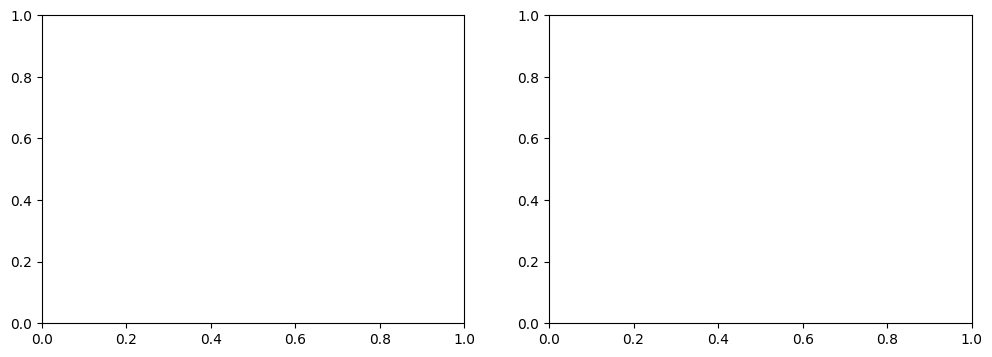

In [13]:
# Plot Phase 1 training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
axes[0].plot(phase1_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Phase 1: Formation Loss')
axes[0].set_yscale('log')

# Smoothed
window = 50
smoothed = np.convolve(phase1_losses, np.ones(window)/window, mode='valid')
axes[0].plot(range(window-1, len(phase1_losses)), smoothed, 'r-', alpha=0.7, label='Smoothed')
axes[0].legend()

# Time per epoch
axes[1].plot(phase1_times)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Time (s)')
axes[1].set_title('Phase 1: Time per Epoch')

plt.tight_layout()
plt.show()

## Phase 2: Multi-Formation Transitions (Goal-Conditioned)

Train the model to switch between different formations based on a goal signal.

**Key improvements:**
- **Goal conditioning**: The NCA receives a 2-channel signal encoding (formation_type, angle)
- **Rotation augmentation**: Targets are randomly rotated during training
- **The model learns to interpret the signal** and produce the corresponding formation

Without goal conditioning, the NCA has no way to know which formation to create - it would just learn an average. With the signal, it can learn distinct behaviors for each formation type and orientation.

In [ ]:
# Phase 2 training with goal conditioning, rotation augmentation, and mass conservation
print("\n" + "="*60)
print("PHASE 2: Multi-Formation Transitions (Goal-Conditioned)")
print("="*60)

if skip_phase2:
    print("Skipping Phase 2 - already trained (loaded from checkpoint)")
    phase2_losses = loaded_checkpoint['metrics'].get('phase2_losses', [])
    phase2_formations = []
else:
    print(f"Rotation augmentation: {USE_ROTATION_AUGMENTATION}")
    print(f"Continuous rotation: {ROTATION_CONTINUOUS}")
    print(f"Intermediate supervision: {NUM_CHECKPOINTS} checkpoints")
    print(f"Mass conservation weight: {MASS_CONSERVATION_WEIGHT}")
    print("Philosophy: Soldiers redistribute into formations, they don't vanish\n")
    
    # Reset pool with trained states
    pool = NCAPool(seed, config.pool_size)
    
    # Formation names for logging
    formation_names = list(targets.keys())
    num_formations = len(formation_names)
    
    # Early stopping config - higher patience for harder task
    PATIENCE = 2000
    MIN_DELTA = 1e-6
    
    # Visualization frequency
    VIZ_INTERVAL = 500  # Show starting/target every N epochs
    
    phase2_losses = []
    phase2_form_losses = []
    phase2_mass_losses = []
    phase2_formations = []
    best_loss = float('inf')
    best_params = state.params  # Start with Phase 1 best
    epochs_without_improvement = 0
    
    for epoch in range(PHASE2_EPOCHS):
        key, subkey1, subkey2, subkey3, subkey4, subkey5 = jax.random.split(key, 6)
        
        # Random target formation
        target_idx = int(jax.random.randint(subkey1, (), 0, num_formations))
        target = targets[formation_names[target_idx]]
        
        # Apply random rotation augmentation
        if USE_ROTATION_AUGMENTATION:
            if ROTATION_CONTINUOUS:
                angle = float(jax.random.uniform(subkey5, (), minval=0, maxval=2 * jnp.pi))
            else:
                # 90 degree increments
                angle = float(jax.random.randint(subkey5, (), 0, 4)) * (jnp.pi / 2)
            target = rotate_formation(target, angle)
        else:
            angle = 0.0
        
        # Create goal-conditioning signal
        formation_signal = create_formation_signal(
            config.batch_size, GRID_SIZE, GRID_SIZE,
            target_idx, angle, num_formations
        )
        
        # Sample from pool
        indices, batch = pool.sample(config.batch_size, subkey2)
        
        # Track batch statistics before training
        batch_mass_before = float(jnp.mean(jnp.sum(batch[..., 3], axis=(1, 2))))
        
        # Visualize starting and target at intervals
        if epoch % VIZ_INTERVAL == 0:
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            
            # Starting state (first sample from batch)
            start_alpha = np.array(batch[0, ..., 3])
            alive_cells = np.sum(start_alpha > 0.1)
            axes[0].imshow(start_alpha, cmap='gray', vmin=0, vmax=1)
            axes[0].set_title(f'Starting State\n(mass: {np.sum(start_alpha):.0f})')
            axes[0].axis('off')
            
            # Target formation
            target_mass = np.sum(np.array(target[..., 3]))
            axes[1].imshow(np.array(target[..., 3]), cmap='gray', vmin=0, vmax=1)
            axes[1].set_title(f'Target: {formation_names[target_idx]}\n(angle: {np.degrees(angle):.0f}°, mass: {target_mass:.0f})')
            axes[1].axis('off')
            
            # Signal values
            sig_vals = f"type={float(formation_signal[0,0,0,0]):.2f}\nangle={float(formation_signal[0,0,0,1]):.2f}"
            axes[2].text(0.5, 0.5, f"Signal:\n{sig_vals}", ha='center', va='center', fontsize=14)
            axes[2].set_title('Formation Signal')
            axes[2].axis('off')
            
            # Pool health: histogram of mass across pool samples
            pool_masses = np.array([float(jnp.sum(batch[i, ..., 3])) for i in range(min(32, config.batch_size))])
            axes[3].hist(pool_masses, bins=20, color='steelblue', edgecolor='black')
            axes[3].axvline(x=np.mean(pool_masses), color='red', linestyle='--', label=f'Mean: {np.mean(pool_masses):.0f}')
            axes[3].set_xlabel('Total Mass (soldiers)')
            axes[3].set_ylabel('Count')
            axes[3].set_title(f'Pool Health\n(soldier count distribution)')
            axes[3].legend()
            
            plt.suptitle(f'Epoch {epoch} | Best Loss: {best_loss:.6f}')
            plt.tight_layout()
            plt.show()
        
        # Damage augmentation (only after warmup - this is the ONLY way soldiers should die)
        if epoch > config.damage_start_epoch:
            batch = pool.apply_damage(batch, config.damage_samples, subkey3)
        
        # Random steps
        num_steps = int(jax.random.randint(subkey4, (), config.min_steps, config.max_steps + 1))
        
        # Train with goal signal
        state, loss, outputs, form_loss, mass_loss = train_step(
            state, batch, target, subkey4, formation_signal, num_steps
        )
        loss_val = float(loss)
        form_loss_val = float(form_loss)
        mass_loss_val = float(mass_loss)
        
        # Track mass after training
        batch_mass_after = float(jnp.mean(jnp.sum(outputs[..., 3], axis=(1, 2))))
        mass_retention = batch_mass_after / (batch_mass_before + 1e-6)
        
        # Early stopping: check for NaN
        if np.isnan(loss_val) or np.isinf(loss_val):
            print(f"\nEarly stopping at epoch {epoch}: loss is {loss_val}")
            if best_params is not None:
                state = state.replace(params=best_params)
            break
        
        # Track best loss
        if loss_val < best_loss - MIN_DELTA:
            best_loss = loss_val
            best_params = state.params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Early stopping: no improvement
        if epochs_without_improvement >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}: no improvement for {PATIENCE} epochs")
            print(f"Best loss: {best_loss:.6f}")
            state = state.replace(params=best_params)
            break
        
        # Update pool
        per_sample_losses = jnp.mean((outputs[..., :4] - target) ** 2, axis=(1, 2, 3))
        pool.update(indices, outputs, per_sample_losses)
        
        phase2_losses.append(loss_val)
        phase2_form_losses.append(form_loss_val)
        phase2_mass_losses.append(mass_loss_val)
        phase2_formations.append(target_idx)
        
        if epoch % config.log_interval == 0:
            rot_str = f", angle={angle:.2f}" if USE_ROTATION_AUGMENTATION else ""
            print(f"Epoch {epoch:4d}: loss = {loss_val:.6f} (form: {form_loss_val:.6f}, mass: {mass_loss_val:.4f}), retention = {mass_retention:.1%}, target = {formation_names[target_idx]}{rot_str}")
    
    print(f"\nPhase 2 complete. Final loss: {phase2_losses[-1]:.6f}, Best loss: {best_loss:.6f}")
    print(f"Average mass loss: {np.mean(phase2_mass_losses):.4f}")

## Save Trained Model

In [15]:
# Save model checkpoint
checkpoint = {
    'params': state.params,
    'config': {
        'grid_size': GRID_SIZE,
        'num_channels': NUM_CHANNELS,
        'hidden_dim': 128,
        'goal_conditioned': True,  # Flag for eval/viz notebooks
        'num_formations': len(targets),
        'formation_names': list(targets.keys()),
    },
    'metrics': {
        'phase1_losses': phase1_losses,
        'phase2_losses': phase2_losses,
    }
}

with open(CHECKPOINT_PATH, 'wb') as f:
    pickle.dump(checkpoint, f)

print(f"Model saved to {CHECKPOINT_PATH}")
print(f"  Goal-conditioned: True")
print(f"  Formations: {list(targets.keys())}")

Model saved to checkpoints/battle_nca_trained.pkl
  Goal-conditioned: True
  Formations: ['line', 'phalanx', 'square', 'wedge', 'column']


## Summary

This notebook demonstrated:
1. **Phase 1**: Training the NCA to grow and maintain a single formation (line)
2. **Phase 2**: Training on multiple formations for goal-conditioned behavior

**Next steps:**
- See `02_evaluation.ipynb` for model evaluation and metrics
- See `03_visualization.ipynb` for animations and detailed visualizations
- For Phase 3 (combat dynamics), use the `HierarchicalNCA` with two armies